# Modelos: Comparativas

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
BASE_PATH             = '../..'
LIB_PATH              = f'{BASE_PATH}/lib'
DATASET_PATH          = f'{BASE_PATH}/datasets'
WEIGHTS_PATH          = f'{BASE_PATH}/weights'
STACKING_PATH         = f'{DATASET_PATH}/stacking'

METRICS_PATH          = f'{BASE_PATH}/metrics/stacking'

MODELS = ['knn_user', 'knn_item', 'knn_ensemble', 'gmf', 'biased_gmf', 'nnmf', 'deep_fm']

In [61]:
import sys
sys.path.append(LIB_PATH)

import torch
from torch.nn import Sigmoid, ReLU
from torch.optim import SparseAdam, Adam
from torch.utils.data import Dataset, DataLoader

from torchmetrics import R2Score
from torch.nn import MSELoss

import pytorch_common.util as pu
from pytorch_common.modules.fn import Fn
from pytorch_common.callbacks import EarlyStop, \
                                     ReduceLROnPlateau, \
                                     Validation, \
                                     SaveBestModel
from pytorch_common.callbacks.output import Logger, \
                                            MetricsPlotter


import data as dt
import data.dataset as ds

import metric as mt
import metric.discretizer as dr

import numpy as np
import pandas as pd

import model as ml
import data.plot as pl

import util as ut

from bunch import Bunch

## Setup

In [4]:
pu.LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

In [5]:
import pytorch_common
pytorch_common.__version__

'0.1.2'

In [6]:
torch.__version__

'1.11.0'

In [7]:
pu.set_device_name('gpu')

pu.get_device(), torch.cuda.is_available()

(device(type='cuda', index=0), True)

In [8]:
def load_dataset(path, models, post_fix):
    datasets = []
    for model in MODELS:
        ds = ut.load_df(f'{path}/{model}_{post_fix}.json')
        ds['model'] = model
        datasets.append(ds)

    return pd.concat(datasets)


def build_dataset(df):
    df = df.pivot(
        index=['user_id', 'movie_id', 'rating'],
        columns='model',
        values=['prediction']
    )
    df.columns = df.columns.droplevel(0)
    return df.reset_index(names=['user_id', 'movie_id', 'rating']).dropna()

In [10]:
train_df = build_dataset(load_dataset(STACKING_PATH, MODELS, 'train'))
test_df  = build_dataset(load_dataset(STACKING_PATH, MODELS, 'test'))

In [11]:
train_df[train_df.isna().any(axis=1)]

model,user_id,movie_id,rating,biased_gmf,deep_fm,gmf,knn_ensemble,knn_item,knn_user,nnmf


In [12]:
test_df[test_df.isna().any(axis=1)]

model,user_id,movie_id,rating,biased_gmf,deep_fm,gmf,knn_ensemble,knn_item,knn_user,nnmf


In [26]:
params = Bunch({
    'lr'              : 0.001,
    'lr_factor'       : 0.1,
    'lr_patience'     : 5,
    'epochs'          : 10,
    'units_per_layer' : [7, 1],
    'activation'      : [ReLU()],
    'dropout'         : [],
    'n_workers'       : 24,
    'batch_norm'      : [],
    'batch_size'      : 16
})

In [36]:
normalizer = dt.Normalizer(train_df, MODELS)

train_norm_df = normalizer(train_df)
train_norm_df.head(3)

train_norm_df[train_norm_df.isna().any(axis=1)]

,knn_user,knn_item,knn_ensemble,gmf,biased_gmf,nnmf,deep_fm,rating,movie_id,user_id


In [37]:
test_norm_df = normalizer(test_df)

test_norm_df[test_norm_df.isna().any(axis=1)]

,knn_user,knn_item,knn_ensemble,gmf,biased_gmf,nnmf,deep_fm,rating,movie_id,user_id


In [38]:
train_ds = ds.BasicDataset(train_norm_df, MODELS, 'rating')
test_ds  = ds.BasicDataset(test_norm_df, MODELS, 'rating')

train_ds.shape, test_ds.shape

(torch.Size([8606]), torch.Size([4475]))

In [39]:
train_dl = DataLoader(train_ds, params.batch_size, num_workers=params.n_workers, pin_memory=True, shuffle = True)
test_dl  = DataLoader(test_ds, params.batch_size, num_workers=params.n_workers, pin_memory=True)

In [50]:
import torch
from torch.nn               import Module
from pytorch_common.modules import CommonMixin, FitMixin, PersistentMixin, PredictMixin

class Stacking(Module, FitMixin, PersistentMixin, PredictMixin):
    def __init__(
        self,
        units_per_layer,
        activation,
        dropout,
        batch_norm
    ):
        super().__init__()
        self.type = 'Stacking'

        self.mlp = ml.MultiLayerPerceptron(
            units_per_layer = units_per_layer,
            activation      = activation,
            dropout         = dropout,
            batch_norm      = batch_norm
        )

    def forward(self, input_data):
        return self.mlp(input_data)

In [53]:
model = Stacking(
    params.units_per_layer,
    params.activation,
    params.dropout,
    params.batch_norm
).to(pu.get_device())
model

Stacking(
  (mlp): MultiLayerPerceptron(
    (mlp): Sequential(
      (0): Linear(in_features=7, out_features=1, bias=True)
      (1): ReLU()
    )
  )
)

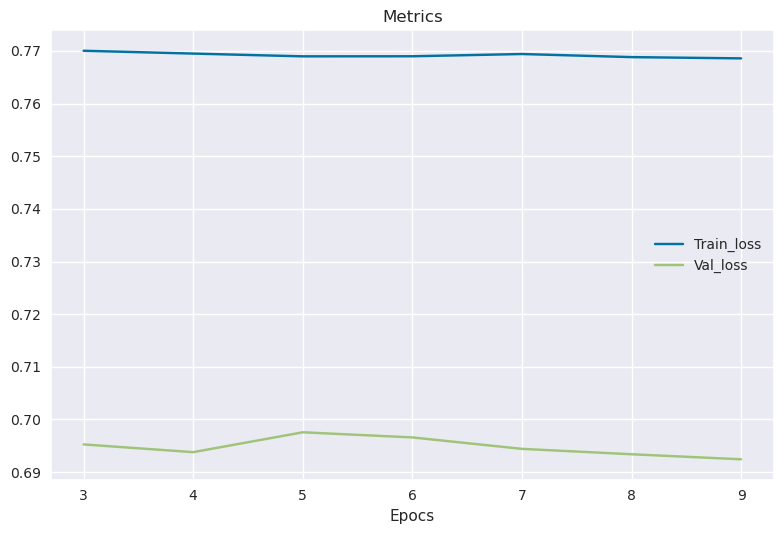

In [55]:
result = model.fit(
    train_dl,
    epochs      = params.epochs,
    loss_fn     = ml.MSELossFn(),
    optimizer   = Adam(
        params       = model.parameters(),
        lr           = params.lr
    ),
    callbacks   = [
        Validation(
            test_dl,
            metrics       = { 'val_loss': ml.MSELossFn(float_result=True)},
            each_n_epochs = 1
        ),
        ReduceLROnPlateau(metric='val_loss', mode='min', factor=params.lr_factor, patience=params.lr_patience),
        Logger(['time', 'epoch', 'train_loss', 'val_loss', 'patience', 'lr']),
        MetricsPlotter(metrics=['train_loss', 'val_loss'], plot_each_n_epochs=5, warmup_count=2),
        # SaveBestModel(metric='val_loss', path=WEIGHTS_PATH, experiment_name='stacking')
    ]
)

In [56]:
def evaluate(model, dl):
    predictions = model.evaluate(dl)
    return predictions[0].flatten(), predictions[1]

r2score = R2Score()

In [57]:
train_pred, train_target = evaluate(model, train_dl)
test_pred, test_target   = evaluate(model, test_dl)

r2score(train_pred, train_target), r2score(test_pred, test_target)

(tensor(0.2650), tensor(0.2226))

In [58]:
n_classes = len(train_df.rating.unique())

validator = ml.Validator(
    n_samples  = 500,
    batch_size = 10000,
    metrics    = [
        mt.RMSE(),
        mt.MeanNdcgAtk            (k=5),
        mt.MeanAveragePrecisionAtk(k=5, discretizer=dr.between(4, 5)),
        mt.MeanUserFBetaScoreAtk  (k=5, n_classes=n_classes, discretizer=dr.between(4, 5)),
        mt.MeanUserPrecisionAtk   (k=5, n_classes=n_classes, discretizer=dr.between(4, 5)),
        mt.MeanUserRecallAtk      (k=5, n_classes=n_classes, discretizer=dr.between(4, 5))
    ],
    predictors = [ml.ModulePredictor(model)],
    y_pred_transform_fn = lambda it: it.squeeze(1),
    y_true_transform_fn = lambda it: it
)

summary = validator.validate(test_ds)
summary.save(METRICS_PATH)

Processing:   0%|          | 0/500 [00:00<?, ?it/s]

In [59]:
summary = ml.ValidatorSummary.load(METRICS_PATH)
summary.show()

Ordered by mAP@5(4,5):


,sample,RMSE,mNDCG@5,"mAP@5(4,5)","MeanUserF1.0Score@5(4,5)","Precision@5(4,5)","Recall@5(4,5)"
predictor,,,,,,,
Stacking,249.5,0.833233,0.999403,0.320838,0.698757,0.698718,0.698751


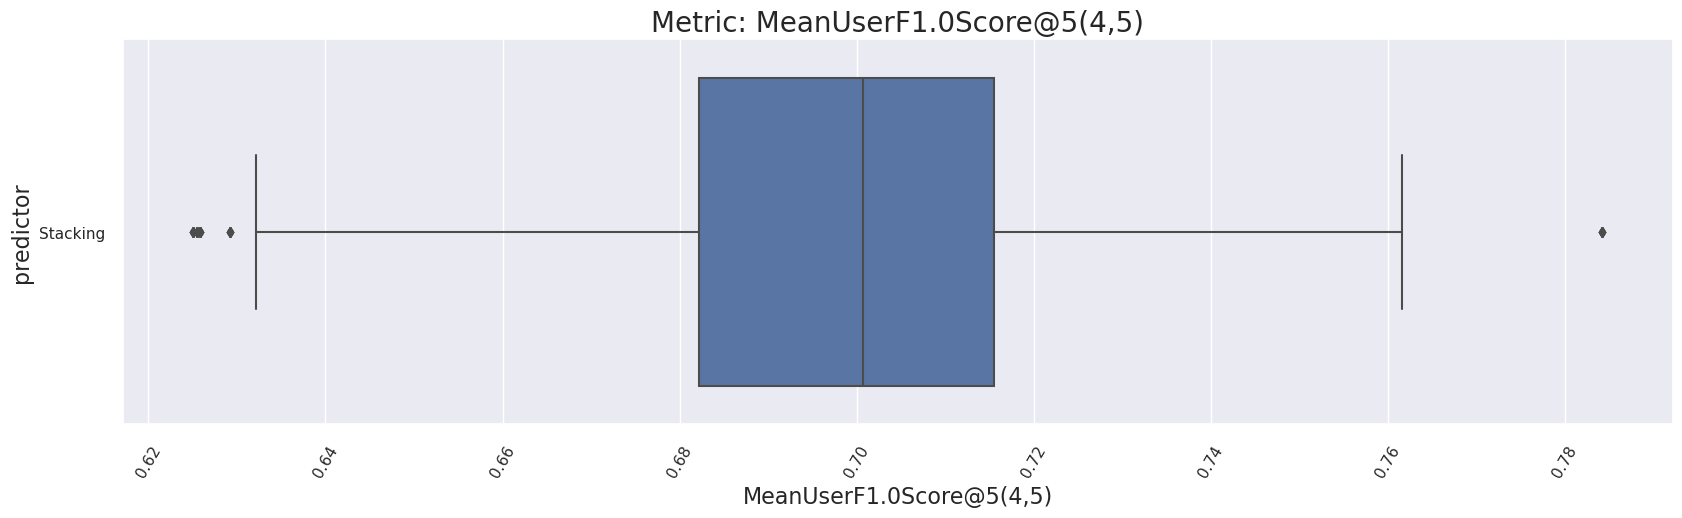

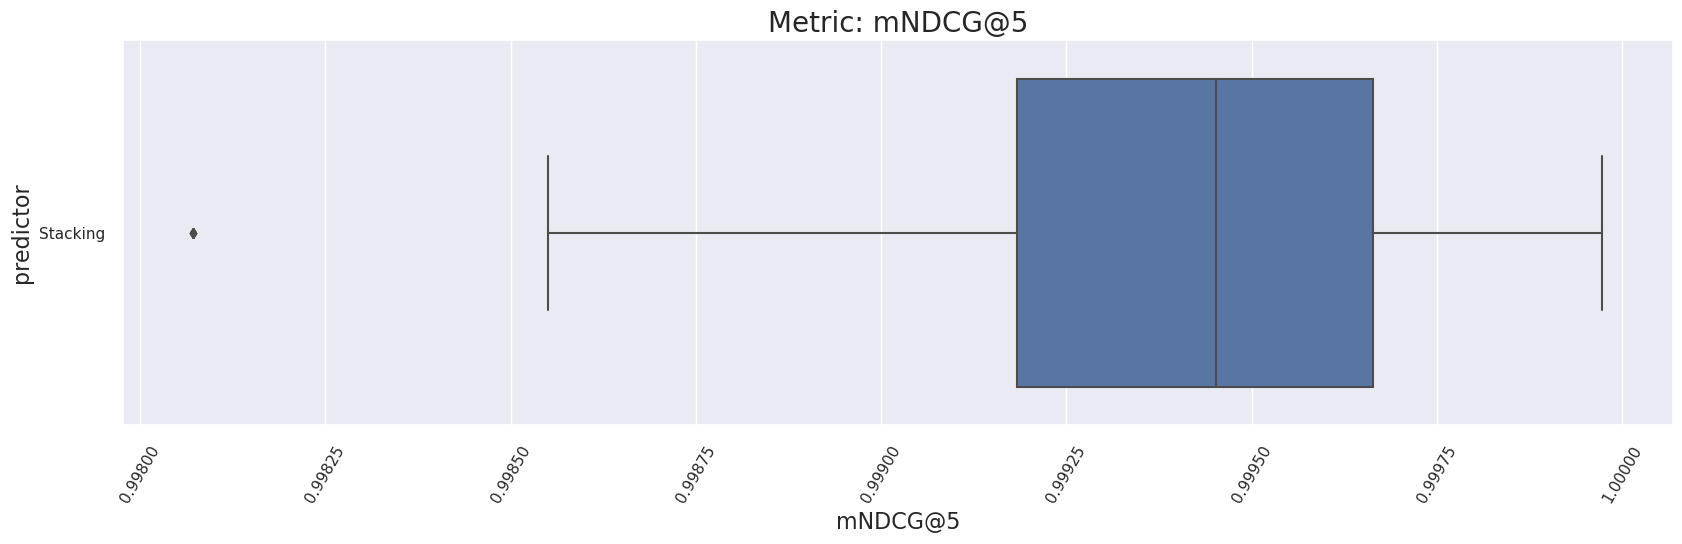

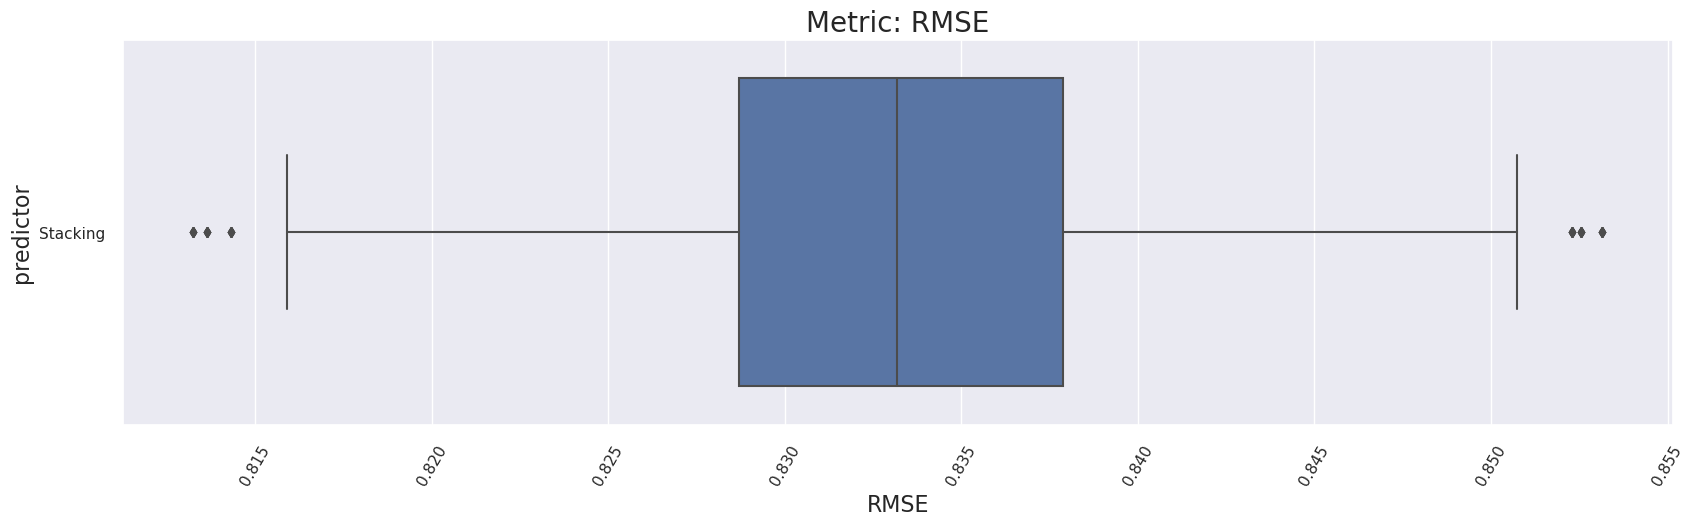

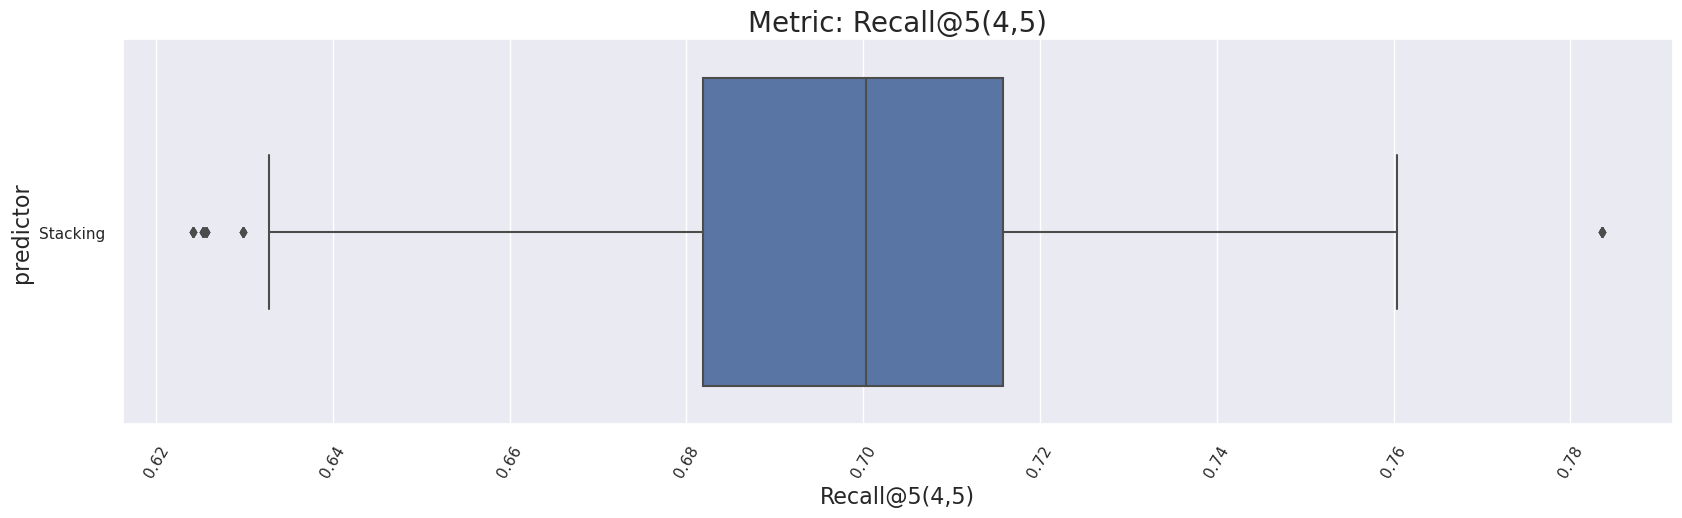

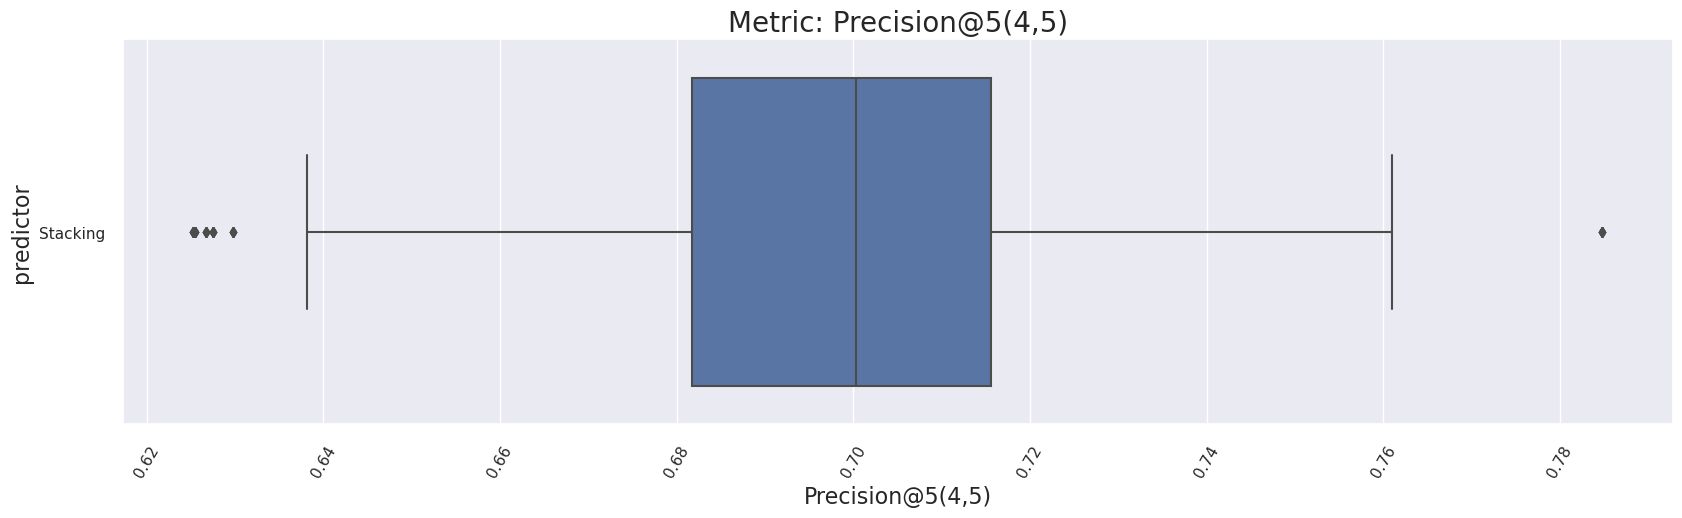

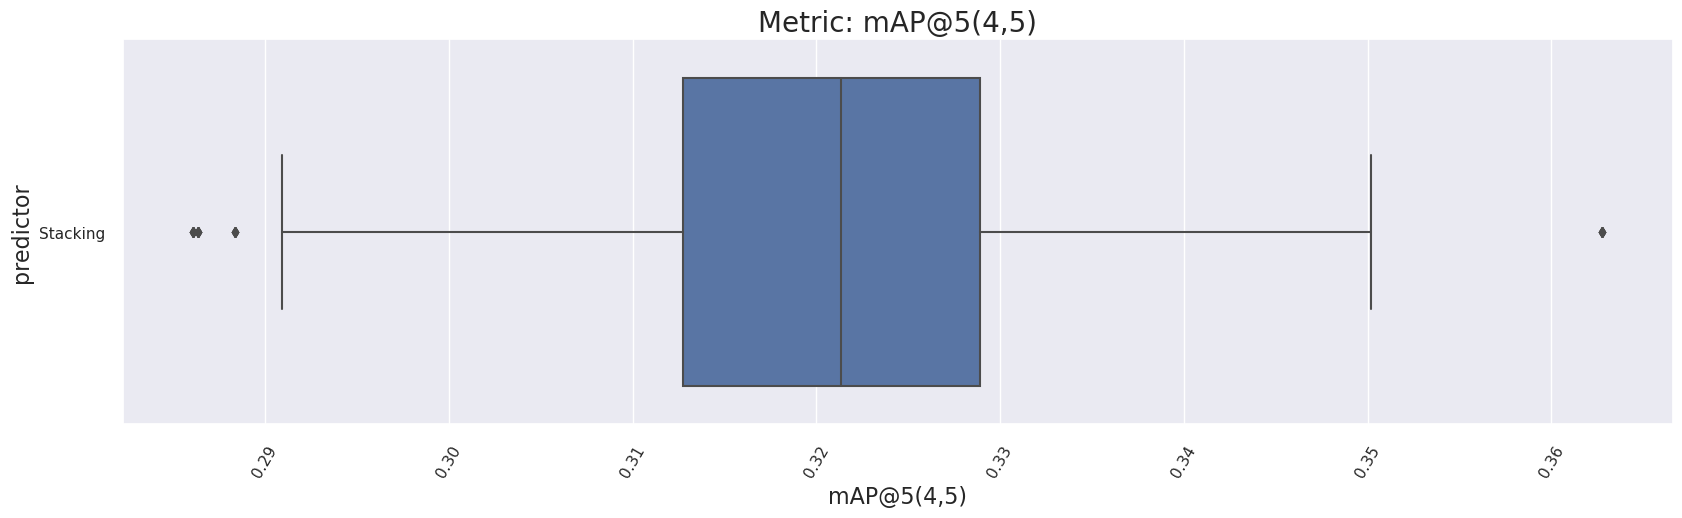

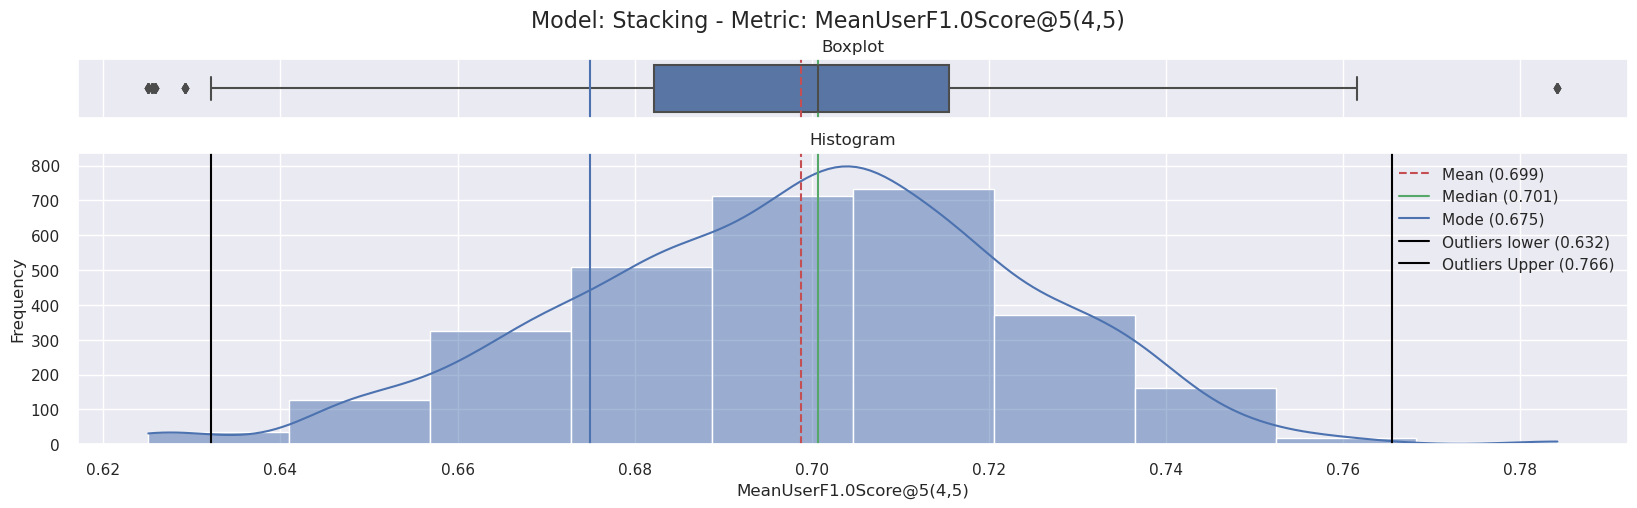

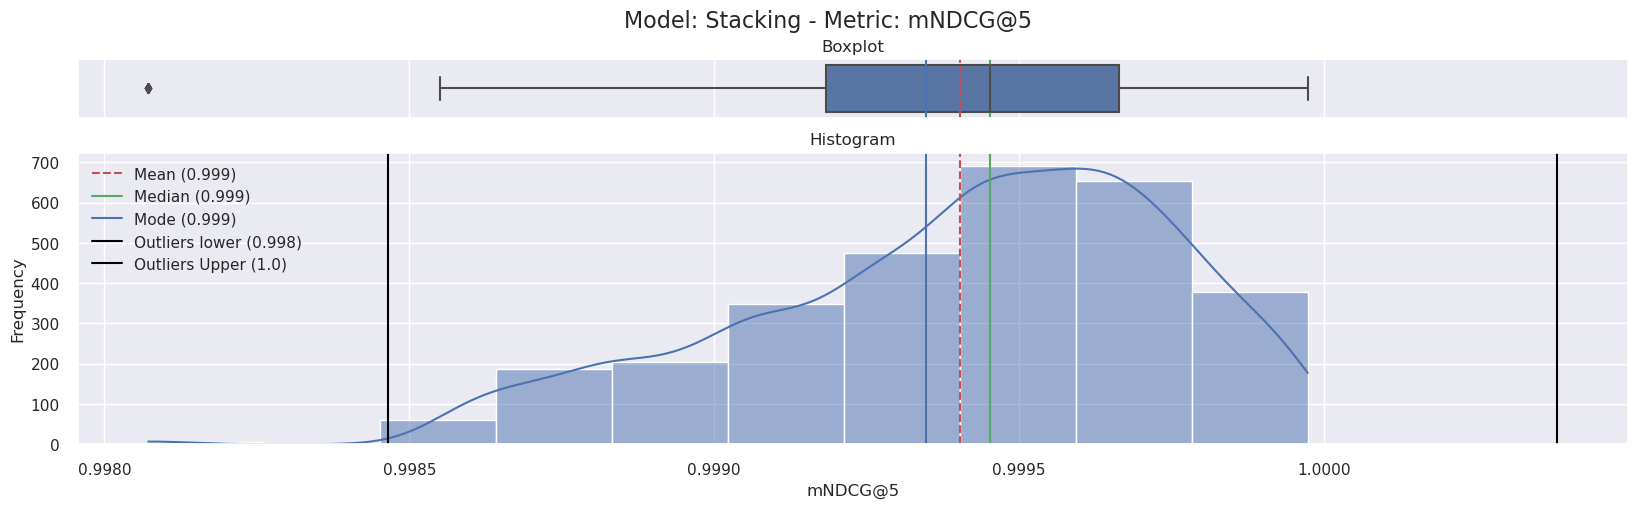

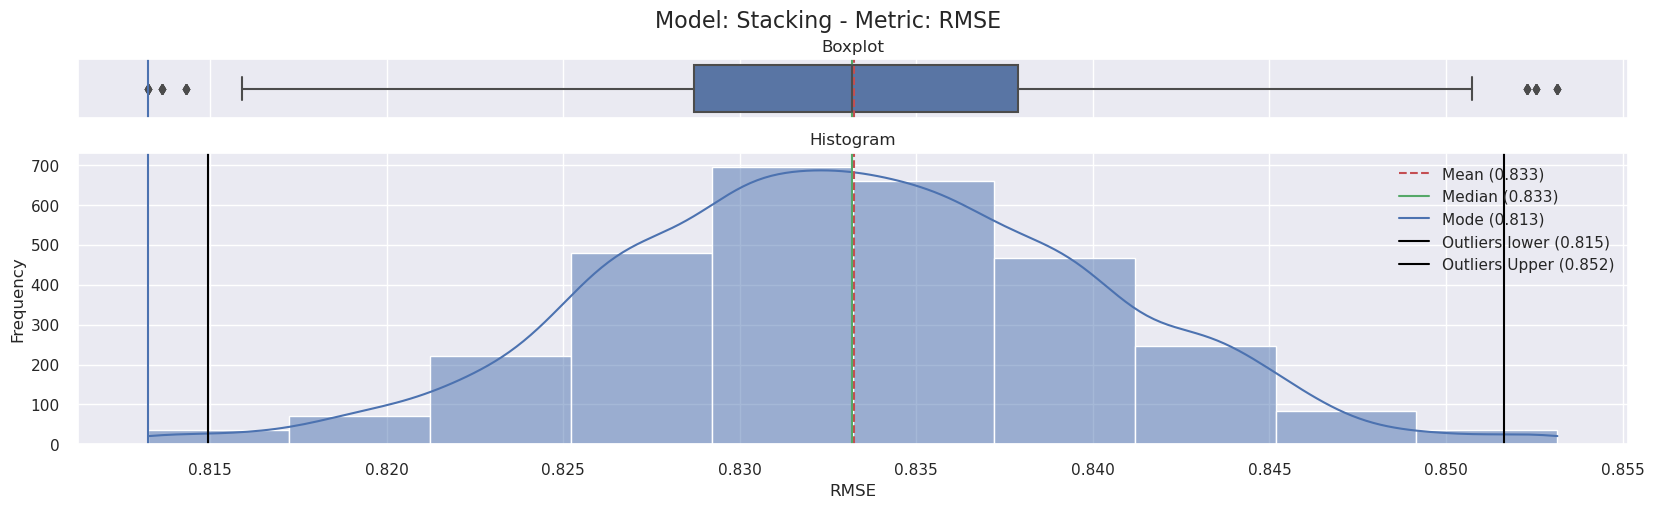

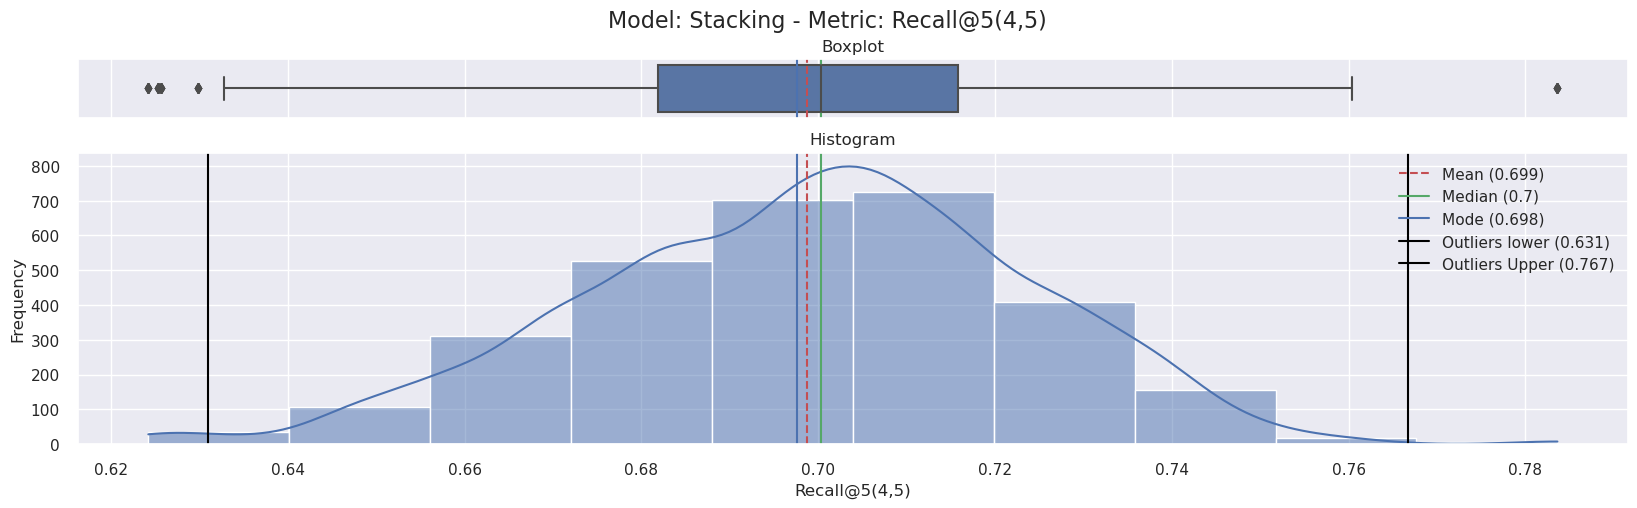

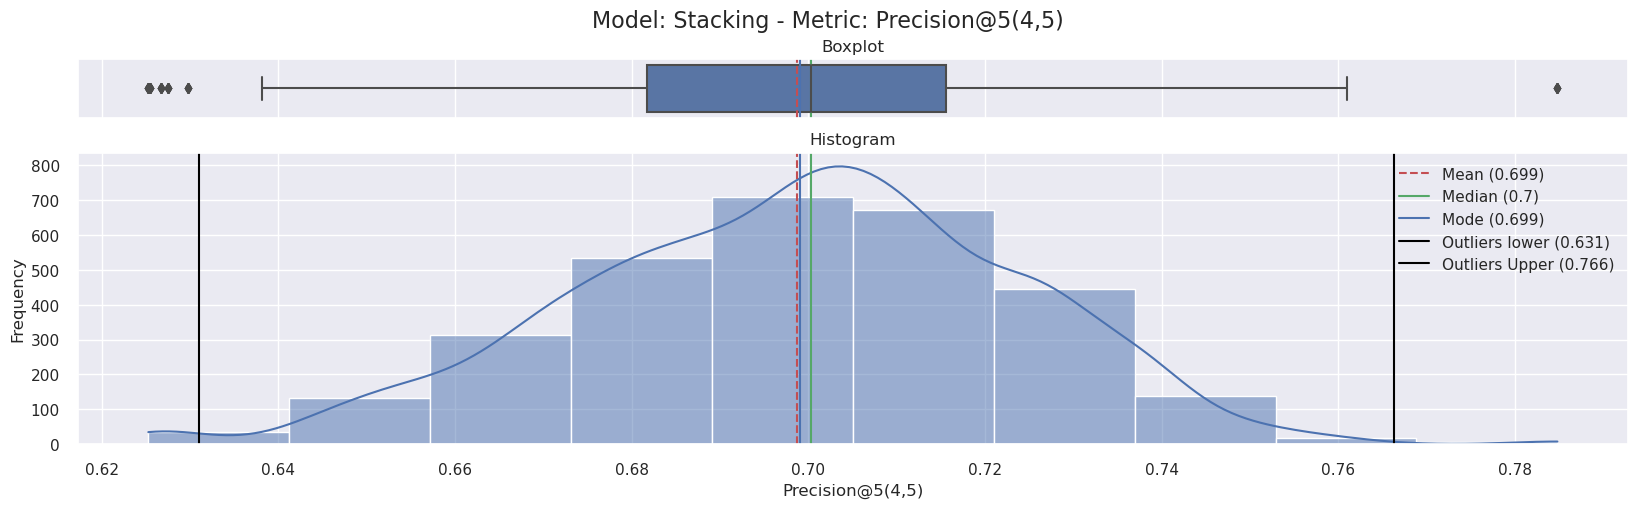

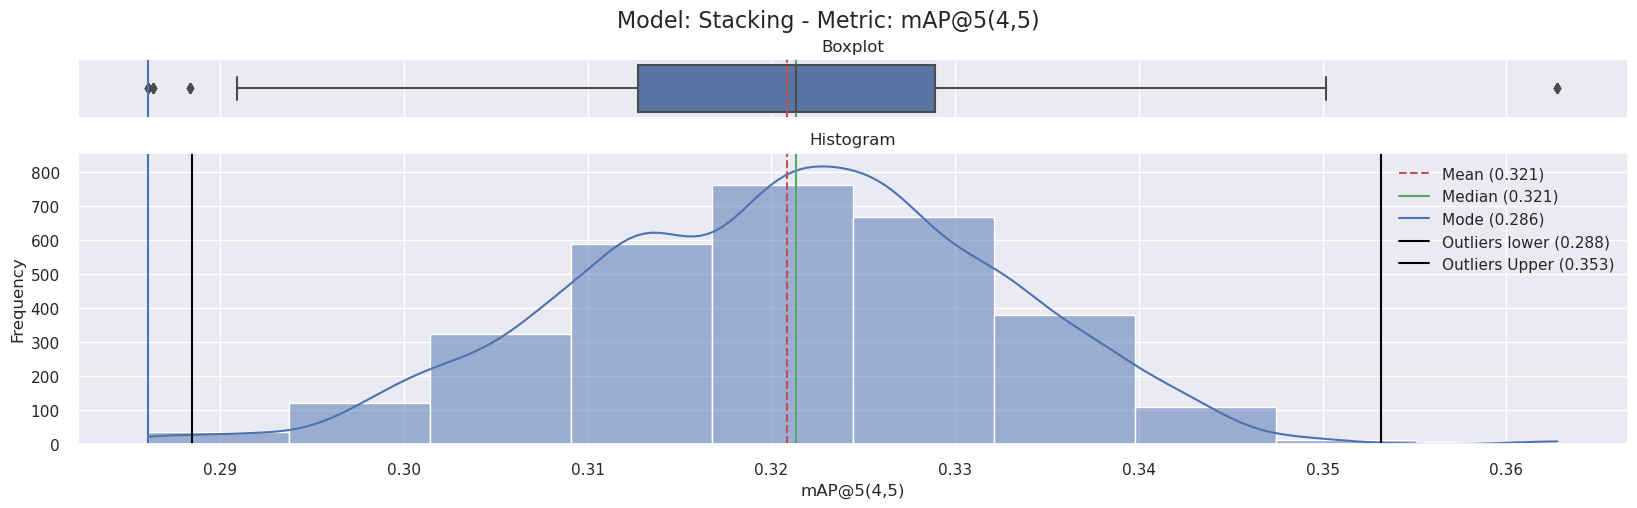

In [60]:
summary.plot()